In [ ]:
!pip install yfinance
!pip install pyyaml==5.4.1
!pip install darts

**I use the Bollinger band indicator and below function to scale the data**

bollingerBands (1).jpg

In [1]:
def preprocessing_func(df):
  df_res = pd.DataFrame()
  period=20
  df_res['SMA_Close'] = df['Close'].rolling(window=period).mean()
  df_res['STD_Close'] = df['Close'].rolling(window=period).std()
  df_res['Upper_Close'] = df_res['SMA_Close'] + (df_res['STD_Close'] *2)
  df_res['Lower_Clsoe'] = df_res['SMA_Close'] - (df_res['STD_Close'] *2)
  df_res['Close_scaled'] = (df['Close'] - df_res['SMA_Close'])/(df_res['Upper_Close']-df_res['Lower_Clsoe'])
  return df_res['Close_scaled'].values

In [2]:
import yfinance
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import darts
from darts import TimeSeries
from darts.metrics import mae, mape
from darts.models import TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import fill_missing_values
from darts.utils.timeseries_generation import datetime_attribute_timeseries

In [3]:
df = yfinance.download(['BTC-USD'], period='700d', interval='1h')[:-1]
df = df.reset_index()
df.columns = ['time', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df['time'] = pd.to_datetime(df.time).dt.tz_localize(None)

[*********************100%***********************]  1 of 1 completed


In [4]:
df.tail(3)

time          Open          High           Low  \
16513 2022-09-05 09:00:00  19781.927734  19792.556641  19743.148438   
16514 2022-09-05 10:00:00  19780.132812  19781.908203  19684.855469   
16515 2022-09-05 11:00:00  19706.777344  19713.253906  19701.853516   

              Close     Adj Close     Volume  
16513  19782.224609  19782.224609  121729024  
16514  19708.001953  19708.001953  405925888  
16515  19712.880859  19712.880859   28766208

In [5]:
df['Close_scaled'] = preprocessing_func(df[['Close']])

In [6]:
df_timeSerie = fill_missing_values(TimeSeries.from_dataframe(df, 'time', ['Close_scaled'], '#Passengers', freq='H'))

In [7]:
train, val = df_timeSerie.split_after(0.8)

scaler_ts = Scaler()
train_ts = scaler_ts.fit_transform(train)
val_ts = scaler_ts.transform(val)

df_timeSerie_sc = scaler_ts.transform(df_timeSerie)

In [8]:
fut_cov = datetime_attribute_timeseries(df_timeSerie, attribute='month', one_hot=False, dtype=np.float32)
fut_cov = fut_cov.stack(
    datetime_attribute_timeseries(df_timeSerie, attribute='day', one_hot=False, dtype=np.float32)
)
fut_cov = fut_cov.stack(
    datetime_attribute_timeseries(df_timeSerie, attribute='hour', one_hot=False, dtype=np.float32)
)
fut_cov = fut_cov.stack(
    TimeSeries.from_times_and_values(
        times = df_timeSerie.time_index,
        values = np.arange(len(df_timeSerie))
    )
)

In [9]:
train_cov, val_cov = fut_cov.split_after(0.8)

scaler_ts_cov = Scaler()
scaler_ts_cov.fit(train_cov)
cov_ts = scaler_ts_cov.transform(fut_cov)

##MODEL

**I use Temporal Fusion Transformers (TFT) Model**

This model supports mixed covariates

In [10]:
forecast_horizon = 1
tft_model = TFTModel(
    input_chunk_length=30,
    output_chunk_length=forecast_horizon,
    hidden_size=128,
    lstm_layers=1,
    num_attention_heads=5,
    dropout=0.1,
    n_epochs=25
)

In [11]:
tft_model.fit(train_ts, future_covariates=cov_ts, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 16.5 K
5  | decoder_vsn                       | _Vari

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [12]:
def model_evaluation(model, n, actual_data, val_data):
  num_samples = 200
  quantile01 , quantile02, quantile03, quantile04 = 0.01, 0.1, 0.9, 0.99
  predicted_data = model.predict(n=n, num_samples=num_samples)

  plt.figure(figsize=(10, 6))
  actual_data[:predicted_data.end_time()][-100:].plot(label="actual")

  predicted_data.plot(
      low_quantile=quantile01,
      high_quantile=quantile04,
      label=f"{int(quantile01*100)}-{int(quantile04*100)}th percntiles"
  )
  predicted_data.plot(
      low_quantile=quantile02, high_quantile=quantile03,
      label=f"{int(quantile02*100)}-{int(quantile03*100)}th percntiles"
  )
  plt.title(f"MAE:{mae(val_data, predicted_data)},\
              MAPE:{mape(val_data, predicted_data)}")


Predicting: 307it [00:00, ?it/s]

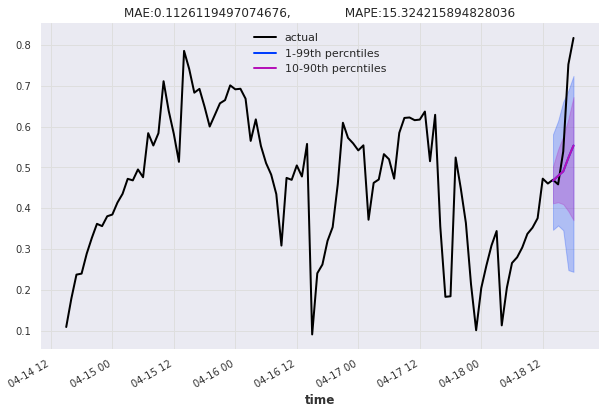

In [13]:
model_evaluation(tft_model, 5, df_timeSerie_sc, val_ts)

In [15]:
hist_forecast = tft_model.historical_forecasts(
    series = df_timeSerie_sc,
    future_covariates=cov_ts,
    start= (train_ts.end_time()+ datetime.timedelta(hours=3000)) + train_ts.freq,
    num_samples=100,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,
    verbose=True,
    retrain=False
)



  0%|          | 0/358 [00:00<?, ?it/s]

Predicting: 307it [00:00, ?it/s]


  0%|          | 1/358 [00:00<02:11,  2.72it/s]

Predicting: 307it [00:00, ?it/s]


  1%|          | 2/358 [00:00<02:20,  2.53it/s]

Predicting: 307it [00:00, ?it/s]


  1%|          | 3/358 [00:01<02:22,  2.50it/s]

Predicting: 307it [00:00, ?it/s]


  1%|          | 4/358 [00:01<02:21,  2.50it/s]

Predicting: 307it [00:00, ?it/s]


  1%|▏         | 5/358 [00:01<02:19,  2.53it/s]

Predicting: 307it [00:00, ?it/s]


  2%|▏         | 6/358 [00:02<02:17,  2.56it/s]

Predicting: 307it [00:00, ?it/s]


  2%|▏         | 7/358 [00:02<02:16,  2.57it/s]

Predicting: 307it [00:00, ?it/s]


  2%|▏         | 8/358 [00:03<02:16,  2.57it/s]

Predicting: 307it [00:00, ?it/s]


  3%|▎         | 9/358 [00:03<02:15,  2.58it/s]

Predicting: 307it [00:00, ?it/s]


  3%|▎         | 10/358 [00:03<02:16,  2.55it/s]

Predicting: 307it [00:00, ?it/s]


  3%|▎         | 11/358 [00:04<02:18,  2.50it/s]

Predicting: 307it [00:00, ?it/s]


  3%|▎         | 12/358 [00:04<02:18,  2.50it/s]

Predicting: 307it [00:00, ?it/s]


  4%|▎         | 13/358 [00:05<02:17,  2.51it/s]

Predicting: 307it [00:00, ?it/s]


  4%|▍         | 14/358 [00:05<02:17,  2.51it/s]

Predicting: 307it [00:00, ?it/s]


  4%|▍         | 15/358 [00:05<02:20,  2.44it/s]

Predicting: 307it [00:00, ?it/s]


  4%|▍         | 16/358 [00:06<02:18,  2.46it/s]

Predicting: 307it [00:00, ?it/s]


  5%|▍         | 17/358 [00:06<02:18,  2.45it/s]

Predicting: 307it [00:00, ?it/s]


  5%|▌         | 18/358 [00:07<02:19,  2.44it/s]

Predicting: 307it [00:00, ?it/s]


  5%|▌         | 19/358 [00:07<02:17,  2.46it/s]

Predicting: 307it [00:00, ?it/s]


  6%|▌         | 20/358 [00:07<02:17,  2.46it/s]

Predicting: 307it [00:00, ?it/s]


  6%|▌         | 21/358 [00:08<02:16,  2.47it/s]

Predicting: 307it [00:00, ?it/s]


  6%|▌         | 22/358 [00:08<02:16,  2.46it/s]

Predicting: 307it [00:00, ?it/s]


  6%|▋         | 23/358 [00:09<02:16,  2.45it/s]

Predicting: 307it [00:00, ?it/s]


  7%|▋         | 24/358 [00:09<02:15,  2.46it/s]

Predicting: 307it [00:00, ?it/s]


  7%|▋         | 25/358 [00:10<02:16,  2.44it/s]

Predicting: 307it [00:00, ?it/s]


  7%|▋         | 26/358 [00:10<02:17,  2.42it/s]

Predicting: 307it [00:00, ?it/s]


  8%|▊         | 27/358 [00:10<02:15,  2.43it/s]

Predicting: 307it [00:00, ?it/s]


  8%|▊         | 28/358 [00:11<02:15,  2.43it/s]

Predicting: 307it [00:00, ?it/s]


  8%|▊         | 29/358 [00:11<02:17,  2.40it/s]

Predicting: 307it [00:00, ?it/s]


  8%|▊         | 30/358 [00:12<02:16,  2.40it/s]

Predicting: 307it [00:00, ?it/s]


  9%|▊         | 31/358 [00:12<02:15,  2.41it/s]

Predicting: 307it [00:00, ?it/s]


  9%|▉         | 32/358 [00:12<02:14,  2.42it/s]

Predicting: 307it [00:00, ?it/s]


  9%|▉         | 33/358 [00:13<02:12,  2.46it/s]

Predicting: 307it [00:00, ?it/s]


  9%|▉         | 34/358 [00:13<02:11,  2.46it/s]

Predicting: 307it [00:00, ?it/s]


 10%|▉         | 35/358 [00:14<02:11,  2.46it/s]

Predicting: 307it [00:00, ?it/s]


 10%|█         | 36/358 [00:14<02:12,  2.43it/s]

Predicting: 307it [00:00, ?it/s]


 10%|█         | 37/358 [00:14<02:10,  2.45it/s]

Predicting: 307it [00:00, ?it/s]


 11%|█         | 38/358 [00:15<02:10,  2.45it/s]

Predicting: 307it [00:00, ?it/s]


 11%|█         | 39/358 [00:15<02:09,  2.46it/s]

Predicting: 307it [00:00, ?it/s]


 11%|█         | 40/358 [00:16<02:08,  2.47it/s]

Predicting: 307it [00:00, ?it/s]


 11%|█▏        | 41/358 [00:16<02:08,  2.46it/s]

Predicting: 307it [00:00, ?it/s]


 12%|█▏        | 42/358 [00:16<02:08,  2.46it/s]

Predicting: 307it [00:00, ?it/s]


 12%|█▏        | 43/358 [00:17<02:08,  2.44it/s]

Predicting: 307it [00:00, ?it/s]


 12%|█▏        | 44/358 [00:17<02:09,  2.43it/s]

Predicting: 307it [00:00, ?it/s]


 13%|█▎        | 45/358 [00:18<02:09,  2.42it/s]

Predicting: 307it [00:00, ?it/s]


 13%|█▎        | 46/358 [00:18<02:09,  2.41it/s]

Predicting: 307it [00:00, ?it/s]


 13%|█▎        | 47/358 [00:19<02:07,  2.43it/s]

Predicting: 307it [00:00, ?it/s]


 13%|█▎        | 48/358 [00:19<02:09,  2.40it/s]

Predicting: 307it [00:00, ?it/s]


 14%|█▎        | 49/358 [00:19<02:07,  2.42it/s]

Predicting: 307it [00:00, ?it/s]


 14%|█▍        | 50/358 [00:20<02:06,  2.44it/s]

Predicting: 307it [00:00, ?it/s]


 14%|█▍        | 51/358 [00:20<02:06,  2.43it/s]

Predicting: 307it [00:00, ?it/s]


 15%|█▍        | 52/358 [00:21<02:04,  2.46it/s]

Predicting: 307it [00:00, ?it/s]


 15%|█▍        | 53/358 [00:21<02:03,  2.46it/s]

Predicting: 307it [00:00, ?it/s]


 15%|█▌        | 54/358 [00:21<02:02,  2.48it/s]

Predicting: 307it [00:00, ?it/s]


 15%|█▌        | 55/358 [00:22<02:05,  2.42it/s]

Predicting: 307it [00:00, ?it/s]


 16%|█▌        | 56/358 [00:22<02:05,  2.40it/s]

Predicting: 307it [00:00, ?it/s]


 16%|█▌        | 57/358 [00:23<02:05,  2.39it/s]

Predicting: 307it [00:00, ?it/s]


 16%|█▌        | 58/358 [00:23<02:06,  2.38it/s]

Predicting: 307it [00:00, ?it/s]


 16%|█▋        | 59/358 [00:24<02:04,  2.39it/s]

Predicting: 307it [00:00, ?it/s]


 17%|█▋        | 60/358 [00:24<02:05,  2.37it/s]

Predicting: 307it [00:00, ?it/s]


 17%|█▋        | 61/358 [00:24<02:06,  2.36it/s]

Predicting: 307it [00:00, ?it/s]


 17%|█▋        | 62/358 [00:25<02:03,  2.40it/s]

Predicting: 307it [00:00, ?it/s]


 18%|█▊        | 63/358 [00:25<02:04,  2.36it/s]

Predicting: 307it [00:00, ?it/s]


 18%|█▊        | 64/358 [00:26<02:03,  2.38it/s]

Predicting: 307it [00:00, ?it/s]


 18%|█▊        | 65/358 [00:26<02:04,  2.36it/s]

Predicting: 307it [00:00, ?it/s]


 18%|█▊        | 66/358 [00:26<02:03,  2.37it/s]

Predicting: 307it [00:00, ?it/s]


 19%|█▊        | 67/358 [00:27<02:04,  2.34it/s]

Predicting: 307it [00:00, ?it/s]


 19%|█▉        | 68/358 [00:27<02:04,  2.32it/s]

Predicting: 307it [00:00, ?it/s]


 19%|█▉        | 69/358 [00:28<02:05,  2.30it/s]

Predicting: 307it [00:00, ?it/s]


 20%|█▉        | 70/358 [00:28<02:05,  2.30it/s]

Predicting: 307it [00:00, ?it/s]


 20%|█▉        | 71/358 [00:29<02:03,  2.32it/s]

Predicting: 307it [00:00, ?it/s]


 20%|██        | 72/358 [00:29<02:02,  2.34it/s]

Predicting: 307it [00:00, ?it/s]


 20%|██        | 73/358 [00:30<02:02,  2.32it/s]

Predicting: 307it [00:00, ?it/s]


 21%|██        | 74/358 [00:30<02:01,  2.33it/s]

Predicting: 307it [00:00, ?it/s]


 21%|██        | 75/358 [00:30<02:02,  2.31it/s]

Predicting: 307it [00:00, ?it/s]


 21%|██        | 76/358 [00:31<02:00,  2.34it/s]

Predicting: 307it [00:00, ?it/s]


 22%|██▏       | 77/358 [00:31<02:00,  2.34it/s]

Predicting: 307it [00:00, ?it/s]


 22%|██▏       | 78/358 [00:32<01:59,  2.34it/s]

Predicting: 307it [00:00, ?it/s]


 22%|██▏       | 79/358 [00:32<02:00,  2.31it/s]

Predicting: 307it [00:00, ?it/s]


 22%|██▏       | 80/358 [00:33<02:00,  2.31it/s]

Predicting: 307it [00:00, ?it/s]


 23%|██▎       | 81/358 [00:33<01:58,  2.34it/s]

Predicting: 307it [00:00, ?it/s]


 23%|██▎       | 82/358 [00:33<01:57,  2.34it/s]

Predicting: 307it [00:00, ?it/s]


 23%|██▎       | 83/358 [00:34<01:57,  2.34it/s]

Predicting: 307it [00:00, ?it/s]


 23%|██▎       | 84/358 [00:34<01:57,  2.32it/s]

Predicting: 307it [00:00, ?it/s]


 24%|██▎       | 85/358 [00:35<01:58,  2.30it/s]

Predicting: 307it [00:00, ?it/s]


 24%|██▍       | 86/358 [00:35<01:59,  2.27it/s]

Predicting: 307it [00:00, ?it/s]


 24%|██▍       | 87/358 [00:36<01:58,  2.29it/s]

Predicting: 307it [00:00, ?it/s]


 25%|██▍       | 88/358 [00:36<01:58,  2.29it/s]

Predicting: 307it [00:00, ?it/s]


 25%|██▍       | 89/358 [00:36<01:56,  2.31it/s]

Predicting: 307it [00:00, ?it/s]


 25%|██▌       | 90/358 [00:37<01:56,  2.31it/s]

Predicting: 307it [00:00, ?it/s]


 25%|██▌       | 91/358 [00:37<01:54,  2.33it/s]

Predicting: 307it [00:00, ?it/s]


 26%|██▌       | 92/358 [00:38<01:56,  2.28it/s]

Predicting: 307it [00:00, ?it/s]


 26%|██▌       | 93/358 [00:38<01:55,  2.29it/s]

Predicting: 307it [00:00, ?it/s]


 26%|██▋       | 94/358 [00:39<01:54,  2.30it/s]

Predicting: 307it [00:00, ?it/s]


 27%|██▋       | 95/358 [00:39<01:54,  2.29it/s]

Predicting: 307it [00:00, ?it/s]


 27%|██▋       | 96/358 [00:39<01:53,  2.30it/s]

Predicting: 307it [00:00, ?it/s]


 27%|██▋       | 97/358 [00:40<01:54,  2.27it/s]

Predicting: 307it [00:00, ?it/s]


 27%|██▋       | 98/358 [00:40<01:54,  2.28it/s]

Predicting: 307it [00:00, ?it/s]


 28%|██▊       | 99/358 [00:41<01:53,  2.27it/s]

Predicting: 307it [00:00, ?it/s]


 28%|██▊       | 100/358 [00:41<01:53,  2.28it/s]

Predicting: 307it [00:00, ?it/s]


 28%|██▊       | 101/358 [00:42<01:54,  2.25it/s]

Predicting: 307it [00:00, ?it/s]


 28%|██▊       | 102/358 [00:42<01:53,  2.25it/s]

Predicting: 307it [00:00, ?it/s]


 29%|██▉       | 103/358 [00:43<01:54,  2.24it/s]

Predicting: 307it [00:00, ?it/s]


 29%|██▉       | 104/358 [00:43<01:53,  2.23it/s]

Predicting: 307it [00:00, ?it/s]


 29%|██▉       | 105/358 [00:44<01:52,  2.24it/s]

Predicting: 307it [00:00, ?it/s]


 30%|██▉       | 106/358 [00:44<01:52,  2.25it/s]

Predicting: 307it [00:00, ?it/s]


 30%|██▉       | 107/358 [00:44<01:51,  2.26it/s]

Predicting: 307it [00:00, ?it/s]


 30%|███       | 108/358 [00:45<01:49,  2.28it/s]

Predicting: 307it [00:00, ?it/s]


 30%|███       | 109/358 [00:45<01:49,  2.27it/s]

Predicting: 307it [00:00, ?it/s]


 31%|███       | 110/358 [00:46<01:48,  2.29it/s]

Predicting: 307it [00:00, ?it/s]


 31%|███       | 111/358 [00:46<01:47,  2.31it/s]

Predicting: 307it [00:00, ?it/s]


 31%|███▏      | 112/358 [00:47<01:47,  2.29it/s]

Predicting: 307it [00:00, ?it/s]


 32%|███▏      | 113/358 [00:47<01:46,  2.30it/s]

Predicting: 307it [00:00, ?it/s]


 32%|███▏      | 114/358 [00:47<01:46,  2.29it/s]

Predicting: 307it [00:00, ?it/s]


 32%|███▏      | 115/358 [00:48<01:45,  2.31it/s]

Predicting: 307it [00:00, ?it/s]


 32%|███▏      | 116/358 [00:48<01:45,  2.30it/s]

Predicting: 307it [00:00, ?it/s]


 33%|███▎      | 117/358 [00:49<01:44,  2.32it/s]

Predicting: 307it [00:00, ?it/s]


 33%|███▎      | 118/358 [00:49<01:44,  2.29it/s]

Predicting: 307it [00:00, ?it/s]


 33%|███▎      | 119/358 [00:50<01:44,  2.28it/s]

Predicting: 307it [00:00, ?it/s]


 34%|███▎      | 120/358 [00:50<01:44,  2.28it/s]

Predicting: 307it [00:00, ?it/s]


 34%|███▍      | 121/358 [00:50<01:44,  2.26it/s]

Predicting: 307it [00:00, ?it/s]


 34%|███▍      | 122/358 [00:51<01:43,  2.29it/s]

Predicting: 307it [00:00, ?it/s]


 34%|███▍      | 123/358 [00:51<01:42,  2.29it/s]

Predicting: 307it [00:00, ?it/s]


 35%|███▍      | 124/358 [00:52<01:43,  2.27it/s]

Predicting: 307it [00:00, ?it/s]


 35%|███▍      | 125/358 [00:52<01:42,  2.27it/s]

Predicting: 307it [00:00, ?it/s]


 35%|███▌      | 126/358 [00:53<01:40,  2.31it/s]

Predicting: 307it [00:00, ?it/s]


 35%|███▌      | 127/358 [00:53<01:38,  2.35it/s]

Predicting: 307it [00:00, ?it/s]


 36%|███▌      | 128/358 [00:54<01:39,  2.31it/s]

Predicting: 307it [00:00, ?it/s]


 36%|███▌      | 129/358 [00:54<01:40,  2.28it/s]

Predicting: 307it [00:00, ?it/s]


 36%|███▋      | 130/358 [00:54<01:40,  2.27it/s]

Predicting: 307it [00:00, ?it/s]


 37%|███▋      | 131/358 [00:55<01:39,  2.28it/s]

Predicting: 307it [00:00, ?it/s]


 37%|███▋      | 132/358 [00:55<01:38,  2.28it/s]

Predicting: 307it [00:00, ?it/s]


 37%|███▋      | 133/358 [00:56<01:39,  2.26it/s]

Predicting: 307it [00:00, ?it/s]


 37%|███▋      | 134/358 [00:56<01:39,  2.26it/s]

Predicting: 307it [00:00, ?it/s]


 38%|███▊      | 135/358 [00:57<01:39,  2.24it/s]

Predicting: 307it [00:00, ?it/s]


 38%|███▊      | 136/358 [00:57<01:37,  2.27it/s]

Predicting: 307it [00:00, ?it/s]


 38%|███▊      | 137/358 [00:58<01:38,  2.25it/s]

Predicting: 307it [00:00, ?it/s]


 39%|███▊      | 138/358 [00:58<01:37,  2.26it/s]

Predicting: 307it [00:00, ?it/s]


 39%|███▉      | 139/358 [00:58<01:36,  2.28it/s]

Predicting: 307it [00:00, ?it/s]


 39%|███▉      | 140/358 [00:59<01:35,  2.28it/s]

Predicting: 307it [00:00, ?it/s]


 39%|███▉      | 141/358 [00:59<01:35,  2.28it/s]

Predicting: 307it [00:00, ?it/s]


 40%|███▉      | 142/358 [01:00<01:36,  2.23it/s]

Predicting: 307it [00:00, ?it/s]


 40%|███▉      | 143/358 [01:00<01:37,  2.21it/s]

Predicting: 307it [00:00, ?it/s]


 40%|████      | 144/358 [01:01<01:36,  2.23it/s]

Predicting: 307it [00:00, ?it/s]


 41%|████      | 145/358 [01:01<01:35,  2.24it/s]

Predicting: 307it [00:00, ?it/s]


 41%|████      | 146/358 [01:02<01:34,  2.25it/s]

Predicting: 307it [00:00, ?it/s]


 41%|████      | 147/358 [01:02<01:34,  2.24it/s]

Predicting: 307it [00:00, ?it/s]


 41%|████▏     | 148/358 [01:02<01:32,  2.27it/s]

Predicting: 307it [00:00, ?it/s]


 42%|████▏     | 149/358 [01:03<01:31,  2.29it/s]

Predicting: 307it [00:00, ?it/s]


 42%|████▏     | 150/358 [01:03<01:30,  2.29it/s]

Predicting: 307it [00:00, ?it/s]


 42%|████▏     | 151/358 [01:04<01:29,  2.31it/s]

Predicting: 307it [00:00, ?it/s]


 42%|████▏     | 152/358 [01:04<01:30,  2.28it/s]

Predicting: 307it [00:00, ?it/s]


 43%|████▎     | 153/358 [01:05<01:30,  2.26it/s]

Predicting: 307it [00:00, ?it/s]


 43%|████▎     | 154/358 [01:05<01:33,  2.18it/s]

Predicting: 307it [00:00, ?it/s]


 43%|████▎     | 155/358 [01:06<01:31,  2.22it/s]

Predicting: 307it [00:00, ?it/s]


 44%|████▎     | 156/358 [01:06<01:32,  2.18it/s]

Predicting: 307it [00:00, ?it/s]


 44%|████▍     | 157/358 [01:06<01:32,  2.17it/s]

Predicting: 307it [00:00, ?it/s]


 44%|████▍     | 158/358 [01:07<01:31,  2.20it/s]

Predicting: 307it [00:00, ?it/s]


 44%|████▍     | 159/358 [01:07<01:30,  2.21it/s]

Predicting: 307it [00:00, ?it/s]


 45%|████▍     | 160/358 [01:08<01:29,  2.21it/s]

Predicting: 307it [00:00, ?it/s]


 45%|████▍     | 161/358 [01:08<01:29,  2.20it/s]

Predicting: 307it [00:00, ?it/s]


 45%|████▌     | 162/358 [01:09<01:28,  2.21it/s]

Predicting: 307it [00:00, ?it/s]


 46%|████▌     | 163/358 [01:09<01:29,  2.18it/s]

Predicting: 307it [00:00, ?it/s]


 46%|████▌     | 164/358 [01:10<01:27,  2.22it/s]

Predicting: 307it [00:00, ?it/s]


 46%|████▌     | 165/358 [01:10<01:26,  2.23it/s]

Predicting: 307it [00:00, ?it/s]


 46%|████▋     | 166/358 [01:11<01:25,  2.24it/s]

Predicting: 307it [00:00, ?it/s]


 47%|████▋     | 167/358 [01:11<01:25,  2.24it/s]

Predicting: 307it [00:00, ?it/s]


 47%|████▋     | 168/358 [01:11<01:26,  2.19it/s]

Predicting: 307it [00:00, ?it/s]


 47%|████▋     | 169/358 [01:12<01:25,  2.21it/s]

Predicting: 307it [00:00, ?it/s]


 47%|████▋     | 170/358 [01:12<01:24,  2.22it/s]

Predicting: 307it [00:00, ?it/s]


 48%|████▊     | 171/358 [01:13<01:23,  2.23it/s]

Predicting: 307it [00:00, ?it/s]


 48%|████▊     | 172/358 [01:13<01:24,  2.21it/s]

Predicting: 307it [00:00, ?it/s]


 48%|████▊     | 173/358 [01:14<01:24,  2.20it/s]

Predicting: 307it [00:00, ?it/s]


 49%|████▊     | 174/358 [01:14<01:22,  2.22it/s]

Predicting: 307it [00:00, ?it/s]


 49%|████▉     | 175/358 [01:15<01:22,  2.23it/s]

Predicting: 307it [00:00, ?it/s]


 49%|████▉     | 176/358 [01:15<01:21,  2.22it/s]

Predicting: 307it [00:00, ?it/s]


 49%|████▉     | 177/358 [01:15<01:21,  2.23it/s]

Predicting: 307it [00:00, ?it/s]


 50%|████▉     | 178/358 [01:16<01:19,  2.25it/s]

Predicting: 307it [00:00, ?it/s]


 50%|█████     | 179/358 [01:16<01:21,  2.19it/s]

Predicting: 307it [00:00, ?it/s]


 50%|█████     | 180/358 [01:17<01:21,  2.19it/s]

Predicting: 307it [00:00, ?it/s]


 51%|█████     | 181/358 [01:17<01:21,  2.18it/s]

Predicting: 307it [00:00, ?it/s]


 51%|█████     | 182/358 [01:18<01:20,  2.18it/s]

Predicting: 307it [00:00, ?it/s]


 51%|█████     | 183/358 [01:18<01:19,  2.20it/s]

Predicting: 307it [00:00, ?it/s]


 51%|█████▏    | 184/358 [01:19<01:18,  2.20it/s]

Predicting: 307it [00:00, ?it/s]


 52%|█████▏    | 185/358 [01:19<01:18,  2.20it/s]

Predicting: 307it [00:00, ?it/s]


 52%|█████▏    | 186/358 [01:20<01:18,  2.20it/s]

Predicting: 307it [00:00, ?it/s]


 52%|█████▏    | 187/358 [01:20<01:17,  2.20it/s]

Predicting: 307it [00:00, ?it/s]


 53%|█████▎    | 188/358 [01:20<01:17,  2.19it/s]

Predicting: 307it [00:00, ?it/s]


 53%|█████▎    | 189/358 [01:21<01:17,  2.18it/s]

Predicting: 307it [00:00, ?it/s]


 53%|█████▎    | 190/358 [01:21<01:17,  2.17it/s]

Predicting: 307it [00:00, ?it/s]


 53%|█████▎    | 191/358 [01:22<01:18,  2.14it/s]

Predicting: 307it [00:00, ?it/s]


 54%|█████▎    | 192/358 [01:22<01:17,  2.15it/s]

Predicting: 307it [00:00, ?it/s]


 54%|█████▍    | 193/358 [01:23<01:16,  2.15it/s]

Predicting: 307it [00:00, ?it/s]


 54%|█████▍    | 194/358 [01:23<01:15,  2.16it/s]

Predicting: 307it [00:00, ?it/s]


 54%|█████▍    | 195/358 [01:24<01:16,  2.14it/s]

Predicting: 307it [00:00, ?it/s]


 55%|█████▍    | 196/358 [01:24<01:15,  2.15it/s]

Predicting: 307it [00:00, ?it/s]


 55%|█████▌    | 197/358 [01:25<01:14,  2.18it/s]

Predicting: 307it [00:00, ?it/s]


 55%|█████▌    | 198/358 [01:25<01:13,  2.16it/s]

Predicting: 307it [00:00, ?it/s]


 56%|█████▌    | 199/358 [01:26<01:12,  2.19it/s]

Predicting: 307it [00:00, ?it/s]


 56%|█████▌    | 200/358 [01:26<01:12,  2.17it/s]

Predicting: 307it [00:00, ?it/s]


 56%|█████▌    | 201/358 [01:27<01:11,  2.19it/s]

Predicting: 307it [00:00, ?it/s]


 56%|█████▋    | 202/358 [01:27<01:12,  2.15it/s]

Predicting: 307it [00:00, ?it/s]


 57%|█████▋    | 203/358 [01:27<01:12,  2.13it/s]

Predicting: 307it [00:00, ?it/s]


 57%|█████▋    | 204/358 [01:28<01:12,  2.14it/s]

Predicting: 307it [00:00, ?it/s]


 57%|█████▋    | 205/358 [01:28<01:11,  2.13it/s]

Predicting: 307it [00:00, ?it/s]


 58%|█████▊    | 206/358 [01:29<01:11,  2.13it/s]

Predicting: 307it [00:00, ?it/s]


 58%|█████▊    | 207/358 [01:29<01:10,  2.14it/s]

Predicting: 307it [00:00, ?it/s]


 58%|█████▊    | 208/358 [01:30<01:09,  2.16it/s]

Predicting: 307it [00:00, ?it/s]


 58%|█████▊    | 209/358 [01:30<01:10,  2.12it/s]

Predicting: 307it [00:00, ?it/s]


 59%|█████▊    | 210/358 [01:31<01:09,  2.14it/s]

Predicting: 307it [00:00, ?it/s]


 59%|█████▉    | 211/358 [01:31<01:08,  2.13it/s]

Predicting: 307it [00:00, ?it/s]


 59%|█████▉    | 212/358 [01:32<01:08,  2.13it/s]

Predicting: 307it [00:00, ?it/s]


 59%|█████▉    | 213/358 [01:32<01:08,  2.11it/s]

Predicting: 307it [00:00, ?it/s]


 60%|█████▉    | 214/358 [01:33<01:07,  2.12it/s]

Predicting: 307it [00:00, ?it/s]


 60%|██████    | 215/358 [01:33<01:07,  2.13it/s]

Predicting: 307it [00:00, ?it/s]


 60%|██████    | 216/358 [01:34<01:07,  2.10it/s]

Predicting: 307it [00:00, ?it/s]


 61%|██████    | 217/358 [01:34<01:06,  2.13it/s]

Predicting: 307it [00:00, ?it/s]


 61%|██████    | 218/358 [01:35<01:06,  2.10it/s]

Predicting: 307it [00:00, ?it/s]


 61%|██████    | 219/358 [01:35<01:06,  2.08it/s]

Predicting: 307it [00:00, ?it/s]


 61%|██████▏   | 220/358 [01:36<01:07,  2.05it/s]

Predicting: 307it [00:00, ?it/s]


 62%|██████▏   | 221/358 [01:36<01:05,  2.08it/s]

Predicting: 307it [00:00, ?it/s]


 62%|██████▏   | 222/358 [01:36<01:04,  2.09it/s]

Predicting: 307it [00:00, ?it/s]


 62%|██████▏   | 223/358 [01:37<01:03,  2.13it/s]

Predicting: 307it [00:00, ?it/s]


 63%|██████▎   | 224/358 [01:37<01:04,  2.09it/s]

Predicting: 307it [00:00, ?it/s]


 63%|██████▎   | 225/358 [01:38<01:03,  2.10it/s]

Predicting: 307it [00:00, ?it/s]


 63%|██████▎   | 226/358 [01:38<01:03,  2.09it/s]

Predicting: 307it [00:00, ?it/s]


 63%|██████▎   | 227/358 [01:39<01:02,  2.08it/s]

Predicting: 307it [00:00, ?it/s]


 64%|██████▎   | 228/358 [01:39<01:02,  2.09it/s]

Predicting: 307it [00:00, ?it/s]


 64%|██████▍   | 229/358 [01:40<01:01,  2.09it/s]

Predicting: 307it [00:00, ?it/s]


 64%|██████▍   | 230/358 [01:40<01:00,  2.10it/s]

Predicting: 307it [00:00, ?it/s]


 65%|██████▍   | 231/358 [01:41<01:00,  2.12it/s]

Predicting: 307it [00:00, ?it/s]


 65%|██████▍   | 232/358 [01:41<00:58,  2.14it/s]

Predicting: 307it [00:00, ?it/s]


 65%|██████▌   | 233/358 [01:42<00:58,  2.14it/s]

Predicting: 307it [00:00, ?it/s]


 65%|██████▌   | 234/358 [01:42<00:58,  2.11it/s]

Predicting: 307it [00:00, ?it/s]


 66%|██████▌   | 235/358 [01:43<00:59,  2.06it/s]

Predicting: 307it [00:00, ?it/s]


 66%|██████▌   | 236/358 [01:43<00:58,  2.09it/s]

Predicting: 307it [00:00, ?it/s]


 66%|██████▌   | 237/358 [01:44<00:58,  2.08it/s]

Predicting: 307it [00:00, ?it/s]


 66%|██████▋   | 238/358 [01:44<00:57,  2.07it/s]

Predicting: 307it [00:00, ?it/s]


 67%|██████▋   | 239/358 [01:45<00:56,  2.09it/s]

Predicting: 307it [00:00, ?it/s]


 67%|██████▋   | 240/358 [01:45<00:57,  2.06it/s]

Predicting: 307it [00:00, ?it/s]


 67%|██████▋   | 241/358 [01:46<00:56,  2.07it/s]

Predicting: 307it [00:00, ?it/s]


 68%|██████▊   | 242/358 [01:46<00:55,  2.07it/s]

Predicting: 307it [00:00, ?it/s]


 68%|██████▊   | 243/358 [01:47<00:55,  2.08it/s]

Predicting: 307it [00:00, ?it/s]


 68%|██████▊   | 244/358 [01:47<00:54,  2.09it/s]

Predicting: 307it [00:00, ?it/s]


 68%|██████▊   | 245/358 [01:47<00:53,  2.10it/s]

Predicting: 307it [00:00, ?it/s]


 69%|██████▊   | 246/358 [01:48<00:54,  2.04it/s]

Predicting: 307it [00:00, ?it/s]


 69%|██████▉   | 247/358 [01:48<00:54,  2.04it/s]

Predicting: 307it [00:00, ?it/s]


 69%|██████▉   | 248/358 [01:49<00:54,  2.04it/s]

Predicting: 307it [00:00, ?it/s]


 70%|██████▉   | 249/358 [01:49<00:52,  2.06it/s]

Predicting: 307it [00:00, ?it/s]


 70%|██████▉   | 250/358 [01:50<00:52,  2.07it/s]

Predicting: 307it [00:00, ?it/s]


 70%|███████   | 251/358 [01:50<00:51,  2.09it/s]

Predicting: 307it [00:00, ?it/s]


 70%|███████   | 252/358 [01:51<00:50,  2.10it/s]

Predicting: 307it [00:00, ?it/s]


 71%|███████   | 253/358 [01:51<00:50,  2.07it/s]

Predicting: 307it [00:00, ?it/s]


 71%|███████   | 254/358 [01:52<00:50,  2.05it/s]

Predicting: 307it [00:00, ?it/s]


 71%|███████   | 255/358 [01:52<00:51,  2.02it/s]

Predicting: 307it [00:00, ?it/s]


 72%|███████▏  | 256/358 [01:53<00:49,  2.04it/s]

Predicting: 307it [00:00, ?it/s]


 72%|███████▏  | 257/358 [01:53<00:49,  2.03it/s]

Predicting: 307it [00:00, ?it/s]


 72%|███████▏  | 258/358 [01:54<00:48,  2.05it/s]

Predicting: 307it [00:00, ?it/s]


 72%|███████▏  | 259/358 [01:54<00:48,  2.03it/s]

Predicting: 307it [00:00, ?it/s]


 73%|███████▎  | 260/358 [01:55<00:48,  2.02it/s]

Predicting: 307it [00:00, ?it/s]


 73%|███████▎  | 261/358 [01:55<00:48,  2.02it/s]

Predicting: 307it [00:00, ?it/s]


 73%|███████▎  | 262/358 [01:56<00:46,  2.05it/s]

Predicting: 307it [00:00, ?it/s]


 73%|███████▎  | 263/358 [01:56<00:46,  2.03it/s]

Predicting: 307it [00:00, ?it/s]


 74%|███████▎  | 264/358 [01:57<00:46,  2.04it/s]

Predicting: 307it [00:00, ?it/s]


 74%|███████▍  | 265/358 [01:57<00:45,  2.04it/s]

Predicting: 307it [00:00, ?it/s]


 74%|███████▍  | 266/358 [01:58<00:45,  2.04it/s]

Predicting: 307it [00:00, ?it/s]


 75%|███████▍  | 267/358 [01:58<00:45,  2.01it/s]

Predicting: 307it [00:00, ?it/s]


 75%|███████▍  | 268/358 [01:59<00:44,  2.01it/s]

Predicting: 307it [00:00, ?it/s]


 75%|███████▌  | 269/358 [01:59<00:44,  2.01it/s]

Predicting: 307it [00:00, ?it/s]


 75%|███████▌  | 270/358 [02:00<00:43,  2.00it/s]

Predicting: 307it [00:00, ?it/s]


 76%|███████▌  | 271/358 [02:00<00:43,  2.02it/s]

Predicting: 307it [00:00, ?it/s]


 76%|███████▌  | 272/358 [02:01<00:42,  2.02it/s]

Predicting: 307it [00:00, ?it/s]


 76%|███████▋  | 273/358 [02:01<00:42,  2.02it/s]

Predicting: 307it [00:00, ?it/s]


 77%|███████▋  | 274/358 [02:02<00:41,  2.02it/s]

Predicting: 307it [00:00, ?it/s]


 77%|███████▋  | 275/358 [02:02<00:40,  2.04it/s]

Predicting: 307it [00:00, ?it/s]


 77%|███████▋  | 276/358 [02:03<00:40,  2.03it/s]

Predicting: 307it [00:00, ?it/s]


 77%|███████▋  | 277/358 [02:03<00:39,  2.04it/s]

Predicting: 307it [00:00, ?it/s]


 78%|███████▊  | 278/358 [02:04<00:39,  2.04it/s]

Predicting: 307it [00:00, ?it/s]


 78%|███████▊  | 279/358 [02:04<00:38,  2.05it/s]

Predicting: 307it [00:00, ?it/s]


 78%|███████▊  | 280/358 [02:05<00:37,  2.07it/s]

Predicting: 307it [00:00, ?it/s]


 78%|███████▊  | 281/358 [02:05<00:36,  2.10it/s]

Predicting: 307it [00:00, ?it/s]


 79%|███████▉  | 282/358 [02:06<00:36,  2.11it/s]

Predicting: 307it [00:00, ?it/s]


 79%|███████▉  | 283/358 [02:06<00:36,  2.06it/s]

Predicting: 307it [00:00, ?it/s]


 79%|███████▉  | 284/358 [02:07<00:36,  2.01it/s]

Predicting: 307it [00:00, ?it/s]


 80%|███████▉  | 285/358 [02:07<00:36,  1.99it/s]

Predicting: 307it [00:00, ?it/s]


 80%|███████▉  | 286/358 [02:08<00:36,  1.97it/s]

Predicting: 307it [00:00, ?it/s]


 80%|████████  | 287/358 [02:08<00:36,  1.94it/s]

Predicting: 307it [00:00, ?it/s]


 80%|████████  | 288/358 [02:09<00:36,  1.93it/s]

Predicting: 307it [00:00, ?it/s]


 81%|████████  | 289/358 [02:09<00:35,  1.93it/s]

Predicting: 307it [00:00, ?it/s]


 81%|████████  | 290/358 [02:10<00:34,  1.95it/s]

Predicting: 307it [00:00, ?it/s]


 81%|████████▏ | 291/358 [02:10<00:34,  1.94it/s]

Predicting: 307it [00:00, ?it/s]


 82%|████████▏ | 292/358 [02:11<00:33,  1.97it/s]

Predicting: 307it [00:00, ?it/s]


 82%|████████▏ | 293/358 [02:11<00:33,  1.97it/s]

Predicting: 307it [00:00, ?it/s]


 82%|████████▏ | 294/358 [02:12<00:32,  1.99it/s]

Predicting: 307it [00:00, ?it/s]


 82%|████████▏ | 295/358 [02:12<00:31,  1.98it/s]

Predicting: 307it [00:00, ?it/s]


 83%|████████▎ | 296/358 [02:13<00:31,  1.97it/s]

Predicting: 307it [00:00, ?it/s]


 83%|████████▎ | 297/358 [02:13<00:31,  1.96it/s]

Predicting: 307it [00:00, ?it/s]


 83%|████████▎ | 298/358 [02:14<00:30,  1.96it/s]

Predicting: 307it [00:00, ?it/s]


 84%|████████▎ | 299/358 [02:14<00:30,  1.94it/s]

Predicting: 307it [00:00, ?it/s]


 84%|████████▍ | 300/358 [02:15<00:29,  1.94it/s]

Predicting: 307it [00:00, ?it/s]


 84%|████████▍ | 301/358 [02:15<00:29,  1.91it/s]

Predicting: 307it [00:00, ?it/s]


 84%|████████▍ | 302/358 [02:16<00:29,  1.90it/s]

Predicting: 307it [00:00, ?it/s]


 85%|████████▍ | 303/358 [02:16<00:28,  1.94it/s]

Predicting: 307it [00:00, ?it/s]


 85%|████████▍ | 304/358 [02:17<00:27,  1.96it/s]

Predicting: 307it [00:00, ?it/s]


 85%|████████▌ | 305/358 [02:17<00:27,  1.96it/s]

Predicting: 307it [00:00, ?it/s]


 85%|████████▌ | 306/358 [02:18<00:26,  1.94it/s]

Predicting: 307it [00:00, ?it/s]


 86%|████████▌ | 307/358 [02:18<00:26,  1.94it/s]

Predicting: 307it [00:00, ?it/s]


 86%|████████▌ | 308/358 [02:19<00:25,  1.94it/s]

Predicting: 307it [00:00, ?it/s]


 86%|████████▋ | 309/358 [02:19<00:25,  1.94it/s]

Predicting: 307it [00:00, ?it/s]


 87%|████████▋ | 310/358 [02:20<00:25,  1.92it/s]

Predicting: 307it [00:00, ?it/s]


 87%|████████▋ | 311/358 [02:21<00:24,  1.93it/s]

Predicting: 307it [00:00, ?it/s]


 87%|████████▋ | 312/358 [02:21<00:23,  1.94it/s]

Predicting: 307it [00:00, ?it/s]


 87%|████████▋ | 313/358 [02:22<00:23,  1.95it/s]

Predicting: 307it [00:00, ?it/s]


 88%|████████▊ | 314/358 [02:22<00:22,  1.94it/s]

Predicting: 307it [00:00, ?it/s]


 88%|████████▊ | 315/358 [02:23<00:22,  1.93it/s]

Predicting: 307it [00:00, ?it/s]


 88%|████████▊ | 316/358 [02:23<00:21,  1.94it/s]

Predicting: 307it [00:00, ?it/s]


 89%|████████▊ | 317/358 [02:24<00:20,  1.97it/s]

Predicting: 307it [00:00, ?it/s]


 89%|████████▉ | 318/358 [02:24<00:20,  1.96it/s]

Predicting: 307it [00:00, ?it/s]


 89%|████████▉ | 319/358 [02:25<00:19,  1.98it/s]

Predicting: 307it [00:00, ?it/s]


 89%|████████▉ | 320/358 [02:25<00:19,  1.99it/s]

Predicting: 307it [00:00, ?it/s]


 90%|████████▉ | 321/358 [02:26<00:19,  1.94it/s]

Predicting: 307it [00:00, ?it/s]


 90%|████████▉ | 322/358 [02:26<00:18,  1.91it/s]

Predicting: 307it [00:00, ?it/s]


 90%|█████████ | 323/358 [02:27<00:18,  1.91it/s]

Predicting: 307it [00:00, ?it/s]


 91%|█████████ | 324/358 [02:27<00:17,  1.90it/s]

Predicting: 307it [00:00, ?it/s]


 91%|█████████ | 325/358 [02:28<00:21,  1.57it/s]

Predicting: 307it [00:00, ?it/s]


 91%|█████████ | 326/358 [02:29<00:19,  1.66it/s]

Predicting: 307it [00:00, ?it/s]


 91%|█████████▏| 327/358 [02:29<00:18,  1.70it/s]

Predicting: 307it [00:00, ?it/s]


 92%|█████████▏| 328/358 [02:30<00:16,  1.77it/s]

Predicting: 307it [00:00, ?it/s]


 92%|█████████▏| 329/358 [02:30<00:16,  1.80it/s]

Predicting: 307it [00:00, ?it/s]


 92%|█████████▏| 330/358 [02:31<00:15,  1.82it/s]

Predicting: 307it [00:00, ?it/s]


 92%|█████████▏| 331/358 [02:31<00:14,  1.84it/s]

Predicting: 307it [00:00, ?it/s]


 93%|█████████▎| 332/358 [02:32<00:13,  1.88it/s]

Predicting: 307it [00:00, ?it/s]


 93%|█████████▎| 333/358 [02:32<00:13,  1.90it/s]

Predicting: 307it [00:00, ?it/s]


 93%|█████████▎| 334/358 [02:33<00:12,  1.89it/s]

Predicting: 307it [00:00, ?it/s]


 94%|█████████▎| 335/358 [02:33<00:11,  1.92it/s]

Predicting: 307it [00:00, ?it/s]


 94%|█████████▍| 336/358 [02:34<00:11,  1.93it/s]

Predicting: 307it [00:00, ?it/s]


 94%|█████████▍| 337/358 [02:34<00:11,  1.90it/s]

Predicting: 307it [00:00, ?it/s]


 94%|█████████▍| 338/358 [02:35<00:10,  1.90it/s]

Predicting: 307it [00:00, ?it/s]


 95%|█████████▍| 339/358 [02:35<00:10,  1.89it/s]

Predicting: 307it [00:00, ?it/s]


 95%|█████████▍| 340/358 [02:36<00:09,  1.92it/s]

Predicting: 307it [00:00, ?it/s]


 95%|█████████▌| 341/358 [02:36<00:08,  1.94it/s]

Predicting: 307it [00:00, ?it/s]


 96%|█████████▌| 342/358 [02:37<00:08,  1.95it/s]

Predicting: 307it [00:00, ?it/s]


 96%|█████████▌| 343/358 [02:37<00:07,  1.99it/s]

Predicting: 307it [00:00, ?it/s]


 96%|█████████▌| 344/358 [02:38<00:07,  1.99it/s]

Predicting: 307it [00:00, ?it/s]


 96%|█████████▋| 345/358 [02:38<00:06,  1.96it/s]

Predicting: 307it [00:00, ?it/s]


 97%|█████████▋| 346/358 [02:39<00:06,  1.94it/s]

Predicting: 307it [00:00, ?it/s]


 97%|█████████▋| 347/358 [02:40<00:05,  1.90it/s]

Predicting: 307it [00:00, ?it/s]


 97%|█████████▋| 348/358 [02:40<00:05,  1.90it/s]

Predicting: 307it [00:00, ?it/s]


 97%|█████████▋| 349/358 [02:41<00:04,  1.83it/s]

Predicting: 307it [00:00, ?it/s]


 98%|█████████▊| 350/358 [02:41<00:04,  1.84it/s]

Predicting: 307it [00:00, ?it/s]


 98%|█████████▊| 351/358 [02:42<00:03,  1.85it/s]

Predicting: 307it [00:00, ?it/s]


 98%|█████████▊| 352/358 [02:42<00:03,  1.88it/s]

Predicting: 307it [00:00, ?it/s]


 99%|█████████▊| 353/358 [02:43<00:02,  1.88it/s]

Predicting: 307it [00:00, ?it/s]


 99%|█████████▉| 354/358 [02:43<00:02,  1.90it/s]

Predicting: 307it [00:00, ?it/s]


 99%|█████████▉| 355/358 [02:44<00:01,  1.94it/s]

Predicting: 307it [00:00, ?it/s]


 99%|█████████▉| 356/358 [02:44<00:01,  1.92it/s]

Predicting: 307it [00:00, ?it/s]


100%|█████████▉| 357/358 [02:45<00:00,  1.96it/s]

Predicting: 307it [00:00, ?it/s]


100%|██████████| 358/358 [02:45<00:00,  2.16it/s]


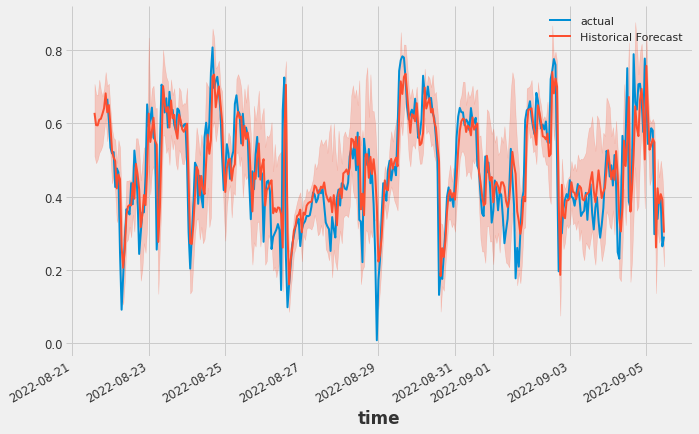

In [22]:
plt.figure(figsize=(10, 6))
df_timeSerie_sc[-350:].plot(label="actual")
hist_forecast.plot(label="Historical Forecast", low_quantile=0.1, high_quantile=0.9)
plt.legend()

In [ ]:
tft_model.save("my_model.pt")
#tft_model = TFTModel.load("my_model.pt")